### Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np
# Suppress warnings
warnings.filterwarnings('ignore')


### Load and Prepare the Data

In [2]:
# Load the dataset 
df = pd.read_csv('data/undersampled_movies_2015_2023_genres.csv')
df.head()

,title,release_year,language,genre,overview,vote_average,vote_count,popularity,cleaned_overview
0,Ava,2020,Amerikanisch,Action,black ops assassin forced fight survival job g...,5.832,2543.0,27.607,black ops assassin forced fight survival job g...
1,Infidel,2019,Amerikanisch,Action,american kidnapped attending conference cairo ...,5.500,74.0,7.443,american kidnapped attending conference cairo ...
2,Quicksand,2023,Amerikanisch,Horror,married couple brink divorce becomes trapped q...,6.589,84.0,11.736,married couple brink divorce becomes trapped q...
3,Earthquake Bird,2019,Amerikanisch,Drama,tokyo japan 1989 lucy fly foreigner work trans...,5.884,426.0,7.835,tokyo japan lucy fly foreigner work translator...
4,First Love,2022,Amerikanisch,Drama,young man difficult entry adulthood experience...,5.672,131.0,15.751,young difficult entry adulthood experience hig...


In [3]:
# Remove lines that contain NAN-Values
df_cleaned = df.dropna()

# Check whether there are still missing values
print(df_cleaned.isnull().sum())


title               0
release_year        0
language            0
genre               0
overview            0
vote_average        0
vote_count          0
popularity          0
cleaned_overview    0
dtype: int64


In [4]:
# Define the features 
X = df_cleaned['cleaned_overview'] + ' ' + df_cleaned['genre'] 
# Predict the language
y = df_cleaned['language'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Feature Engineering

In [5]:
# Apply TF-IDF Vectorizer to the combined text features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [6]:
# Initialize Logistic Regression with class balancing and parameter tuning
log_reg = LogisticRegression(max_iter=1000)

# Define the parameter grid for Logistic Regression
param_grid_reduced = [
    {'penalty': ['l1', 'l2'], 'C': [1, 10, 100], 'solver': ['liblinear']},
    {'penalty': ['elasticnet'], 'C': [1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0, 0.5, 1]}
]

# Apply Grid Search with Cross-Validation to find the best parameters
grid_search_reduced = GridSearchCV(log_reg, param_grid_reduced, cv=5, verbose=1)
grid_search_reduced.fit(X_train_tfidf, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid=[{'C': [1, 10, 100], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [1, 10, 100], 'l1_ratio': [0, 0.5, 1],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             verbose=1)

In [7]:
# Output best parameters found
print("Best parameters found: ", grid_search_reduced.best_params_)

Best parameters found:  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [8]:
# Make predictions on the test set
y_pred = grid_search_reduced.predict(X_test_tfidf)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6332236842105263


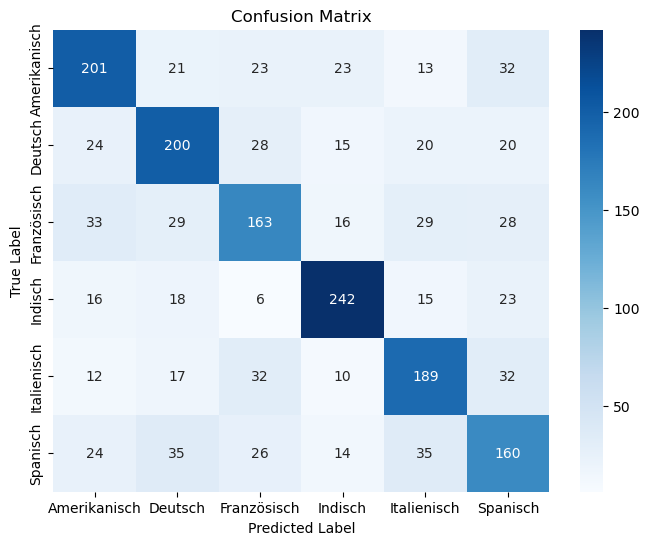

In [9]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=grid_search_reduced.classes_, 
            yticklabels=grid_search_reduced.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Generate a classification report
classification_report_result = classification_report(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=grid_search_reduced.classes_)

print(classification_report_result)


              precision    recall  f1-score   support

Amerikanisch       0.65      0.64      0.65       313
     Deutsch       0.62      0.65      0.64       307
 Französisch       0.59      0.55      0.57       298
     Indisch       0.76      0.76      0.76       320
 Italienisch       0.63      0.65      0.64       292
    Spanisch       0.54      0.54      0.54       294

    accuracy                           0.63      1824
   macro avg       0.63      0.63      0.63      1824
weighted avg       0.63      0.63      0.63      1824

